In [13]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lightgbm as lgb
import catboost as cb
from keras.wrappers.scikit_learn import KerasRegressor
from keras import Sequential
from keras.layers import Dense

from tsfresh.examples import load_robot_execution_failures
from tsfresh import extract_features, select_features
import optuna

from common import EP
from models import *
from dfdb import DFDB

import types
import os
import copy

import seaborn as sns
import matplotlib.pyplot as plt

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# os.environ["CUDA_VISIBLE_DEVICES"]="3";  

In [2]:
pd.set_option('display.max_colwidth', -1)

In [3]:
%%HTML
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 65%; }
   div#maintoolbar-container { width: 99%; }
</style>

In [4]:
def m_lineplot(dflist, plot_features=None, n_col=3):

    
    n_chart = len(dflist)
    n_row = int(n_chart/n_col) if n_chart % n_col == 0 else n_row+1
        
    fig = plt.figure(figsize=(5*n_col, 3*n_row))
    for i, df in enumerate(dflist):
        ax = fig.add_subplot(n_row, n_col, i+1)
        if type(plot_features) == type(None):
            plot_features = df.columns.tolist()
        for feat in plot_features:
            sns.lineplot(x=df.index, y=df[feat], ax=ax)
    return 

In [5]:
df_train = pd.read_pickle('../feats/df_train.pkl')
df_test = pd.read_pickle('../feats/df_test.pkl')

In [6]:
df_train['label'] = df_train['y'].apply(lambda x:  int(x) if x<15 else 15)
group = df_train['season'].values
group[np.where(group==17)[0]] = 1
df_train['group'] = group
df_train = df_train.drop(columns=['season'])

In [7]:
test_X = df_train.drop(columns=['y','index','group','label']).copy()
test_X.index = df_train['index']
test_y = df_train['y'].copy()
test_y.index = df_train['index']
tsfresh_columns = select_features(test_X, test_y).columns.tolist()

In [8]:
original_columns = df_train.columns.drop(['index','y','label','group']).tolist()

In [9]:
common_columns50 = ["number_peaks{'n': 5}",
 'abs_q75_6',
 'q01_roll_std_100',
 '5000crest_factor_quantile75',
 'abs_q01_4',
 'q25_roll_std_100',
 'q05_roll_std_10',
 'median__roll_std',
 'abs_q05_6',
 '5000form_factor_quantile75',
 '5000smoothness_quantile05',
 "quantile{'q': 0.9}",
 'abs_q75_2',
 'q01_roll_std_1000',
 '5000quantile75mean_',
 'spkt_welch_density__coeff_3',
 "number_peaks{'n': 10}",
 "number_peaks{'n': 1}",
 '5000smoothness_mean_',
 'abs_q25_5',
 '5000std_quantile05',
 '5000smoothness_std_',
 '5000smoothness_median_',
 '5000median_variance_',
 'spkt_welch_density__coeff_4',
 '5000variance_quantile25',
 'abs_q95_2',
 'abs_q75_7',
 'q05_5',
 '5000smoothness_entropy_',
 '5000smoothness_quantile25',
 'q01_2',
 'q05_roll_std_100',
 '3th_peak_freq',
 "autocorrelation{'lag': 5}",
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'q01_roll_std_10',
 'abs_q01_3',
 '5000variance_median_',
 'q75_roll_std_10',
 '5000skewness_max_',
 'iqr_3',
 'abs_q01_5',
 'q75_roll_mean_10',
 '5000quantile99median_',
 'iqr_6',
 'Hilbert_mean_6',
 'q05_roll_std_1000',
 "number_peaks{'n': 3}",
 'spkt_welch_densitycoeff_2',
 '5000std_median_',
 '5000std_quantile25']

In [10]:
common_columns75 = ['abs_q75_6',
 'abs_q01_4',
 'q25_roll_std_100',
 'q05_roll_std_10',
 'median__roll_std',
 '5000smoothness_quantile05',
 'spkt_welch_density__coeff_3',
 "number_peaks{'n': 10}",
 'abs_q25_5',
 'abs_q75_7',
 'q05_5',
 'q05_roll_std_100',
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'iqr_6',
 'q05_roll_std_1000']

In [11]:
common_columns95 = ['abs_q75_6',
 'abs_q01_4',
 'q25_roll_std_100',
 "number_peaks{'n': 10}",
 'abs_q25_5',
 'q05_roll_std_100',
 'iqr_6',
 'q05_roll_std_1000']

In [16]:
db = DFDB('../trial2/kerasmlp.pkl', auto_commit=False)
db.select().shape

(0, 0)

In [17]:
len(common_columns50),len(common_columns75),len(common_columns95)

(52, 15, 8)

In [60]:
path_param={
    'input_dim':52,
    'hidden_layer_sizes':[64, 16],
    'activation':'relu',
    'l1l2regularizer':None,
    'dropout':.3,
}
base_save_dir = create_path('KerasMLPRegressor', path_param)
param={
    'algorithm': {
        'cls': 'KerasMLPRegressor',
        'fit': {
            'versbose':0, 
            'epochs':50, 
            'early_stopping_rounds':20,
        },
        'init': {
            'batch':128, 
            'solver':'adam', 
            'metric':'mean_absolute_error', 
            'lr':.0001, 
            'sgd_momentum':.9, 
            'sgd_decay':0.0001,
            'base_save_dir':base_save_dir, 
            'alias':'kerasmlp',
            **path_param
        }
    },
    'columns': common_columns50,
    'kfold': {
        'n_splits': 3,
        'random_state': 1985,
        'shuffle': True,
        'type': 'group'#stratified
    },
    'scaler': {
        'cls': 'StandardScaler'
    }
}

In [ ]:
# run one try
mytrial = []
df_his,  df_feature_importances, df_valid_pred, df_test_pred =  EP.process(df_train, param, df_test = df_test, trial=mytrial)
db.insert(mytrial[0])
df_trial = db.select()

In [66]:
df_trial['kfold-type'] = df_trial['param'].apply(lambda x: x['kfold']['type'])
df_trial['algorithm-init'] = df_trial['param'].apply(lambda x: x['algorithm']['init'])
df_trial[['datetime','nfeatures', 'kfold-type', 'algorithm-init', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,nfeatures,kfold-type,algorithm-init,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
0,2019-05-20 03:17:00.036329,52,group,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor/input_dim=52,hidden_layer_sizes=[512, 64],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 52, 'hidden_layer_sizes': [512, 64], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",1.719521,0.001195,2.202497,0.003352,0.482976
1,2019-05-20 03:59:20.953064,15,group,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor/input_dim=15,hidden_layer_sizes=[128, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 15, 'hidden_layer_sizes': [128, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",1.962702,0.001743,2.095119,0.018669,0.132416
2,2019-05-20 04:10:33.387380,15,group,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor/input_dim=15,hidden_layer_sizes=[64, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 15, 'hidden_layer_sizes': [64, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",1.974893,0.002249,2.084937,0.016540,0.110044
3,2019-05-20 04:31:58.892823,8,group,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor/input_dim=8,hidden_layer_sizes=[64, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 8, 'hidden_layer_sizes': [64, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",2.011699,0.002986,2.092593,0.018385,0.080894
4,2019-05-20 04:47:50.530474,15,stratified,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor/input_dim=15,hidden_layer_sizes=[64, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 15, 'hidden_layer_sizes': [64, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",1.997296,0.000077,2.006472,0.000015,0.009176
5,2019-05-20 05:13:44.729127,8,stratified,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor/input_dim=8,hidden_layer_sizes=[64, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 8, 'hidden_layer_sizes': [64, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",2.035242,0.000116,2.042545,0.000120,0.007303
6,2019-05-20 05:26:04.460335,52,stratified,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor/input_dim=52,hidden_layer_sizes=[64, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 52, 'hidden_layer_sizes': [64, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",1.931558,0.000003,1.953183,0.000050,0.021624
7,2019-05-20 05:46:08.237023,52,stratified,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor/input_dim=52,hidden_layer_sizes=[512, 64],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 52, 'hidden_layer_sizes': [512, 64], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",1.783952,0.000174,1.867055,0.000046,0.083103
8,2019-05-20 06:02:55.058381,52,group,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 's

In [67]:
df_his_list = [pd.read_csv(param['algorithm']['init']['base_save_dir'] + '/{}_{}_train_his.csv'.format(param['algorithm']['init']['alias'], i), index_col=0) for i in range(param['kfold']['n_splits'])]

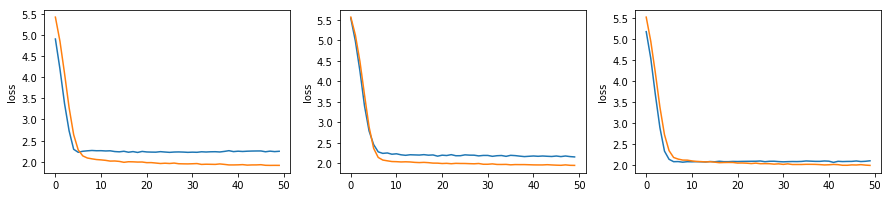

In [68]:
m_lineplot(df_his_list)

In [69]:
db.commit()